# Modelling and Evaluating 

## Objectives

- Answer business requirement 2:
  - The client is interested to tell wheterh a given leaf is covered with powdery mildew 

## Inputs

- image shape embeddings (pickle file)
- Images from the test, train, validation folders and their subfolders. 
    ```bash
    . 
    ├── inputs 
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves                                     
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew                   
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew          
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew                 
    └── ...
    ```

* Images distribution plot in train, validation, and test set.
  * label distribution - bar chart
  * set distriburion - pie chart (percentages)
* Image augmentation.
  * plot augmented images for each set.
* Class indices to change prediction inference in labels.
* Creation of a Machine learning model and display of its summary
* Model training. 
* Save model.
* Learning curve plot for model performance.
  * Model A - separate plots for accuracy and loss
  * Model B - comprehensive model history plot 
  * Model C - plot model history with plotly
* Model evaluation on saved file.
  * calculate accuracy
  * plot ROC curve
  * calculate classification report (Model A)
    * Model B - classification report with macro avg and weighted avg
    * Model C - syntetic classification report per label
* Plot Confusion Matrix
* Save evaluation pickle file
* Prediction on the random image file.

## Comments | Insights

- The same data was plotted in different versions to accomodate possible client's requests of further data understanding. 
- The CNN was built seeking maximise accuracy while minimizing loss and training time.
- The CNN was kept as small as possible withouth compromising accuracy and avoiding overfitting. 
- More about hyperparameters optimization and trial and error phase is documented in the readme.md file and in a separate .pdf file.

---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

## Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/CLMP-Detector/')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/CLMP-Detector'

---

## Set input directories

In [5]:
# Define input paths for training, validation, and testing datasets

data_directory = 'inputs/cherryleaves_dataset/cherry-leaves'
train_dir = data_directory + '/train'
validation_dir = data_directory + '/validation'
test_dir = data_directory + '/test'

## Set output directory

In [6]:
# Set the output directory for saving model results and Create a new version if necessary.

version = 'v1'
file_path = os.path.join('outputs', version)

if os.path.exists(os.path.join(work_dir, 'outputs')) and os.path.exists(file_path):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)

Old version is already available, create a new version.


## Set Label names

In [7]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image Distribution

### Count the number of images per set and label

In [10]:
# Prepare an empty DataFrame for counting images
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Count'])

# Loop through each folder (train, test, validation) and count images in each label (healthy, powdery_mildew)
for folder in ['train', 'test', 'validation']:
    for label in labels:
        count = len(os.listdir(os.path.join(data_directory, folder, label)))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Count': count}, ignore_index=True)
        print(f"* {folder} - {label}: {count} images")

print("\n", df_freq)

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images

           Set           Label Count
0       train         healthy  1472
1       train  powdery_mildew  1472
2        test         healthy   422
3        test  powdery_mildew   422
4  validation         healthy   210
5  validation  powdery_mildew   210


### Label Distribution - Bar Chart

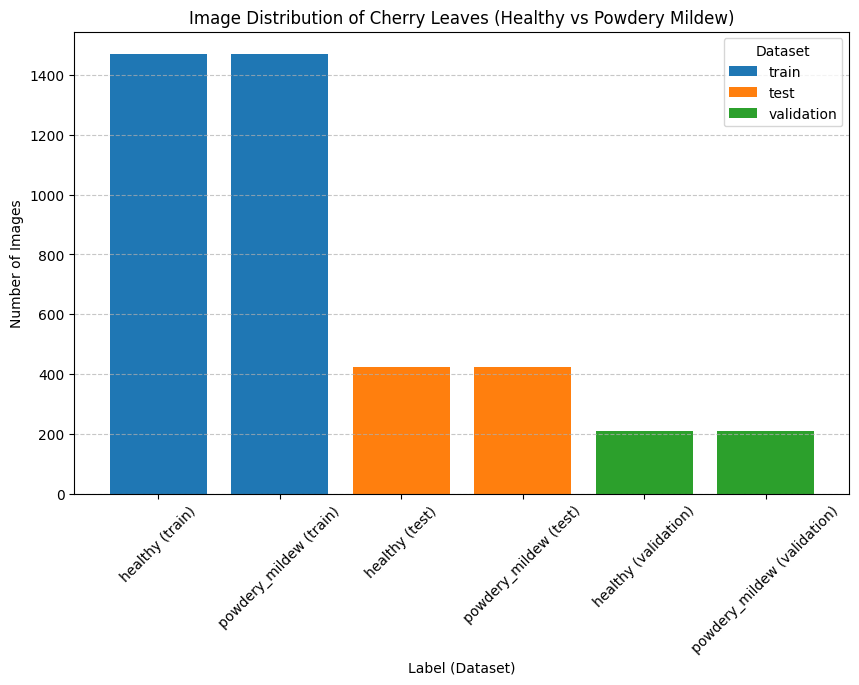

In [11]:
# Bar plot to visualize the image distribution
plt.figure(figsize=(10, 6))
for folder in ['train', 'test', 'validation']:
    subset = df_freq[df_freq['Set'] == folder]
    plt.bar(subset['Label'] + ' (' + folder + ')', subset['Count'], label=folder)

# Adding labels and title
plt.title('Image Distribution of Cherry Leaves (Healthy vs Powdery Mildew)')
plt.xlabel('Label (Dataset)')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Set Distribution - Pie Chart

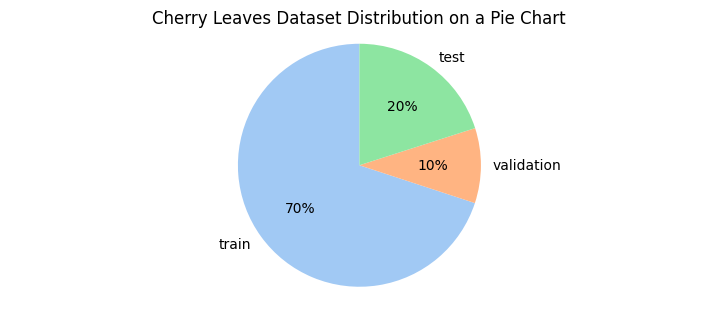

In [16]:
# Define the folder names for train, validation, and test sets
folders = ['train', 'validation', 'test']

# Initialize variables to store data distribution across sets
data = []

# Loop through the folders (train, validation, test) and count the number of images for each
for folder in folders:
    n = 0
    for label in labels:
        n += len(os.listdir(os.path.join(data_directory, folder, label)))
    data.append(n)

# Create the pie chart using Matplotlib
px = 1 / plt.rcParams['figure.dpi']  # Adjusting size for display
plt.subplots(figsize=(900 * px, 350 * px))
colors = sns.color_palette('pastel')[0:5]  # Using pastel colors for the pie chart
plt.pie(data, labels=folders, colors=colors, autopct='%.0f%%', startangle=90)
plt.title('Cherry Leaves Dataset Distribution on a Pie Chart')
plt.axis('equal')  # Ensures pie chart is a perfect circle
plt.savefig(f'{file_path}/sets_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image Data Augmentation

In [17]:
# Import necessary libraries for modeling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

### Data Preprocessing – Image Augmentation

In [21]:
# Data Preprocessing: Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Set Batch size

In [26]:
batch_size = 20

### Augment training image set

In [27]:
train_set = train_datagen.flow_from_directory(train_dir,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Training Images

(20, 256, 256, 3)


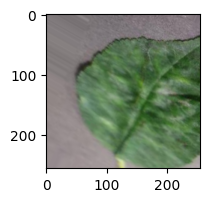

(20, 256, 256, 3)


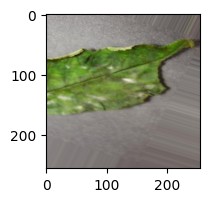

(20, 256, 256, 3)


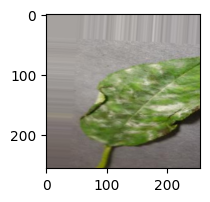

In [28]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [29]:
validation_set = validation_datagen.flow_from_directory(validation_dir, 
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices  # Display the class indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Validation Images

(20, 256, 256, 3)


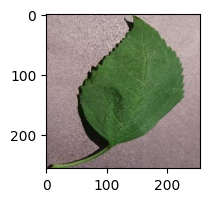

(20, 256, 256, 3)


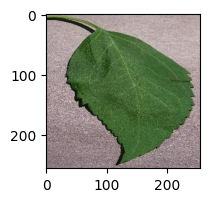

(20, 256, 256, 3)


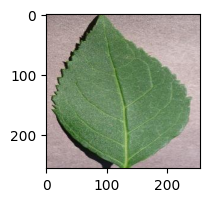

In [30]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Test Image Set

In [31]:
test_set = test_datagen.flow_from_directory(test_dir, 
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices  # Display the class indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Test Images

(20, 256, 256, 3)


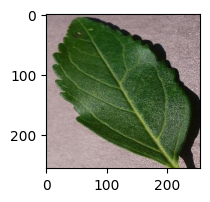

(20, 256, 256, 3)


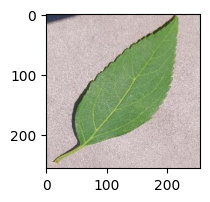

(20, 256, 256, 3)


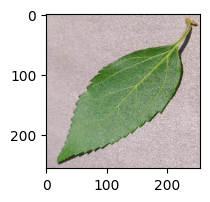

In [32]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [33]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Build the CNN Model

This step involves building the CNN model with convolutional, pooling, flattening, and dense layers.

In [34]:
# Model Building
model = Sequential()

# Add Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add Flattening and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to prevent overfitting

2024-09-21 10:27:40.398604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
